In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import pacf as pacf_func
from statsmodels.graphics.tsaplots import acf as acf_func
import statsmodels.graphics.tsaplots as tsa

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

from statsmodels.tsa.arima.model import ARIMA

plt.style.use("ggplot")

import plotly.graph_objects as go

from statsmodels.tsa.stattools import adfuller

# <font face="gotham" color="purple"> AR Model </font>

We have introduced $\text{AR}$ and $\text{MA}$ models in previous chapters, in this chapter we will discuss the practical issues of both models.
$$
\text{AR(1)}: \qquad Y_{t}=\phi_0+\phi_{1} Y_{t-1}+u_{t}
$$
If $\phi<0$, the time series exhibits mean-reversion feature, if $\phi>0$ exhibits trend-following feature. One reminder, ```ArmaProcess``` needs zero lag coefficient $1$ to be input explicitly and the sign from lag $1$ onward must be sign-reversed.


In [14]:
ar_params = np.array([1, 0.9])
ma_params = np.array([1])
ar1 = ArmaProcess(ar_params, ma_params)
ar1_sim = ar1.generate_sample(nsample=100)
ar1_sim = pd.DataFrame(ar1_sim, columns=["AR(1)"])
ar1_acf = acf_func(ar1_sim.values, fft=False, nlags=50)

ar_params1 = np.array([1, -0.9])
ma_params1 = np.array([1])
ar1_pos = ArmaProcess(ar_params1, ma_params1)
ar1_sim_pos = ar1_pos.generate_sample(nsample=100)
ar1_sim_pos = pd.DataFrame(ar1_sim_pos, columns=["AR(1)"])
ar1_acf_pos = acf_func(ar1_sim_pos.values, fft=False, nlags=50)

ar_params2 = np.array([1, -0.8, -0.2])
ma_params2 = np.array([1])
ar2 = ArmaProcess(ar_params2, ma_params2)
ar2_sim = ar2.generate_sample(nsample=100)
ar2_sim = pd.DataFrame(ar2_sim, columns=["AR(2)"])
ar2_acf = acf_func(ar2_sim.values, fft=False, nlags=50)

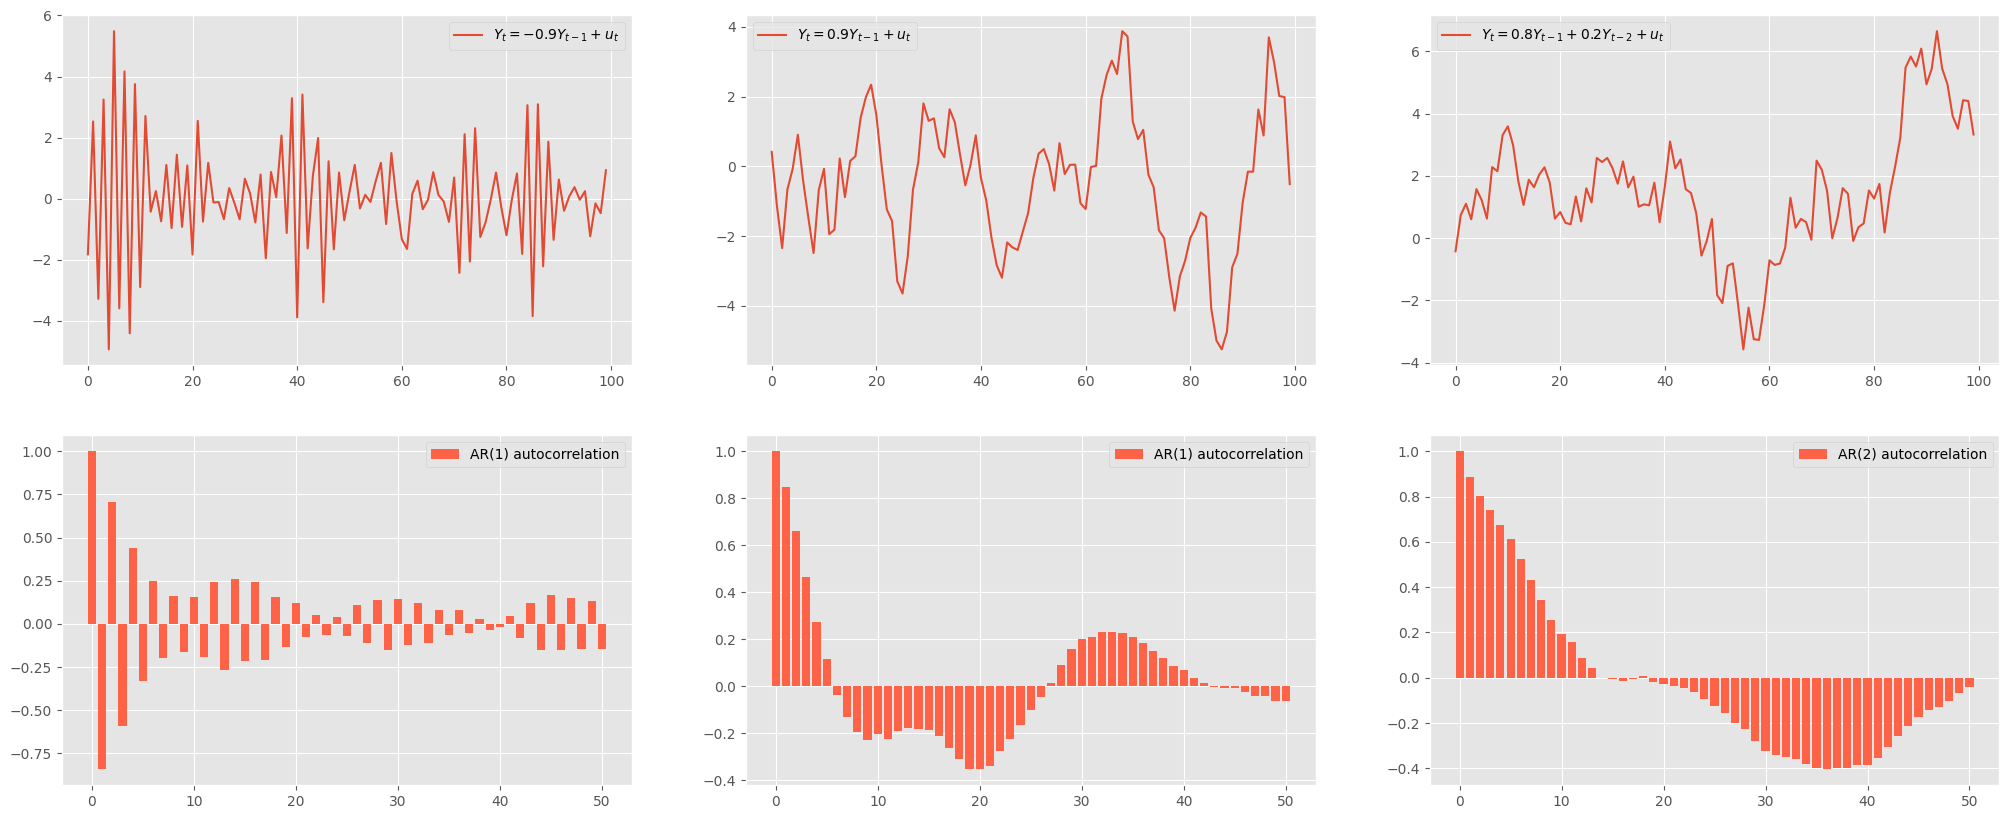

In [15]:
fig, ax = plt.subplots(figsize=(25, 10), nrows=2, ncols=3)
ax[0, 0].plot(ar1_sim, label="$Y_t = {%s}Y_{t-1}+u_t$" % (-ar_params[1]))
ax[0, 0].legend()
ax[1, 0].bar(
    np.arange(len(ar1_acf)), ar1_acf, color="tomato", label="AR(1) autocorrelation"
)
ax[1, 0].legend()

ax[0, 1].plot(ar1_sim_pos, label="$Y_t = {%s}Y_{t-1}+u_t$" % (-ar_params1[1]))
ax[0, 1].legend()
ax[1, 1].bar(
    np.arange(len(ar1_acf_pos)),
    ar1_acf_pos,
    color="tomato",
    label="AR(1) autocorrelation",
)
ax[1, 1].legend()

ax[0, 2].plot(
    ar2_sim,
    label="$Y_t = {%s} Y_{t-1}+{%s} Y_{t-2}+u_t$" % (-ar_params2[1], -ar_params2[2]),
)
ax[0, 2].legend()
ax[1, 2].bar(
    np.arange(len(ar2_acf)), ar2_acf, color="tomato", label="AR(2) autocorrelation"
)
ax[1, 2].legend()
plt.show()

# <font face="gotham" color="purple">  Estimation and Forecast of AR</font> 

Output ```sigma2``` is the variance of residuals. 

In [16]:
mod_obj = ARIMA(ar1_sim_pos, order=(1, 0, 0))
result = mod_obj.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  AR(1)   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -145.824
Date:                Sun, 09 Jun 2024   AIC                            297.648
Time:                        19:00:01   BIC                            305.464
Sample:                             0   HQIC                           300.811
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4271      0.639     -0.669      0.504      -1.679       0.825
ar.L1          0.8397      0.057     14.730      0.000       0.728       0.951
sigma2         1.0686      0.156      6.868      0.0

In [17]:
res_predict = result.predict(start=5, end=110)

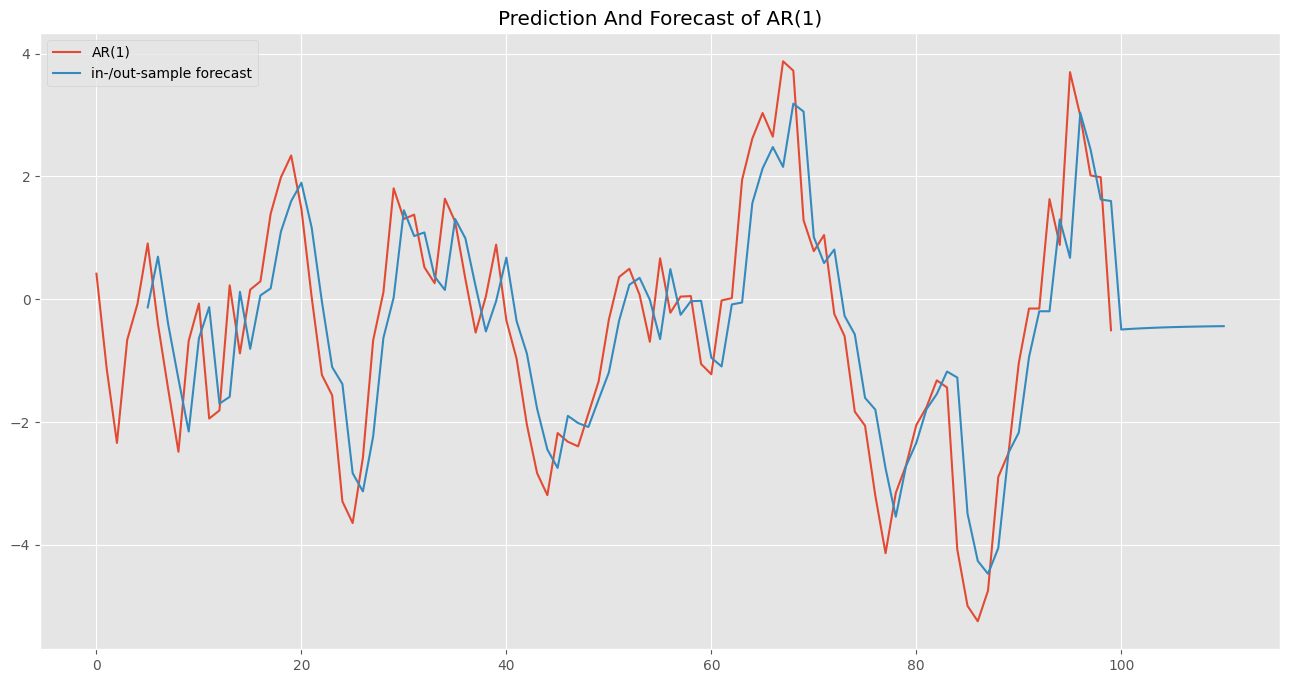

In [18]:
ar1_sim_pos.plot(figsize=(16, 8))
res_predict.plot(
    label="in-/out-sample forecast", title="Prediction And Forecast of AR(1)"
)
plt.legend()
plt.show()

# <font face="gotham" color="purple">Identification of the Order of an AR Model </font>

The usual practice of order identification is called **the Box-Jenkins Methodology**, which will be explicated below, for now we simply perform two techniques:
1. Partial Autocorrelation Function
2. Akaike or Bayesian Information Criteria ($\text{AIC}$, $\text{BIC}$)|

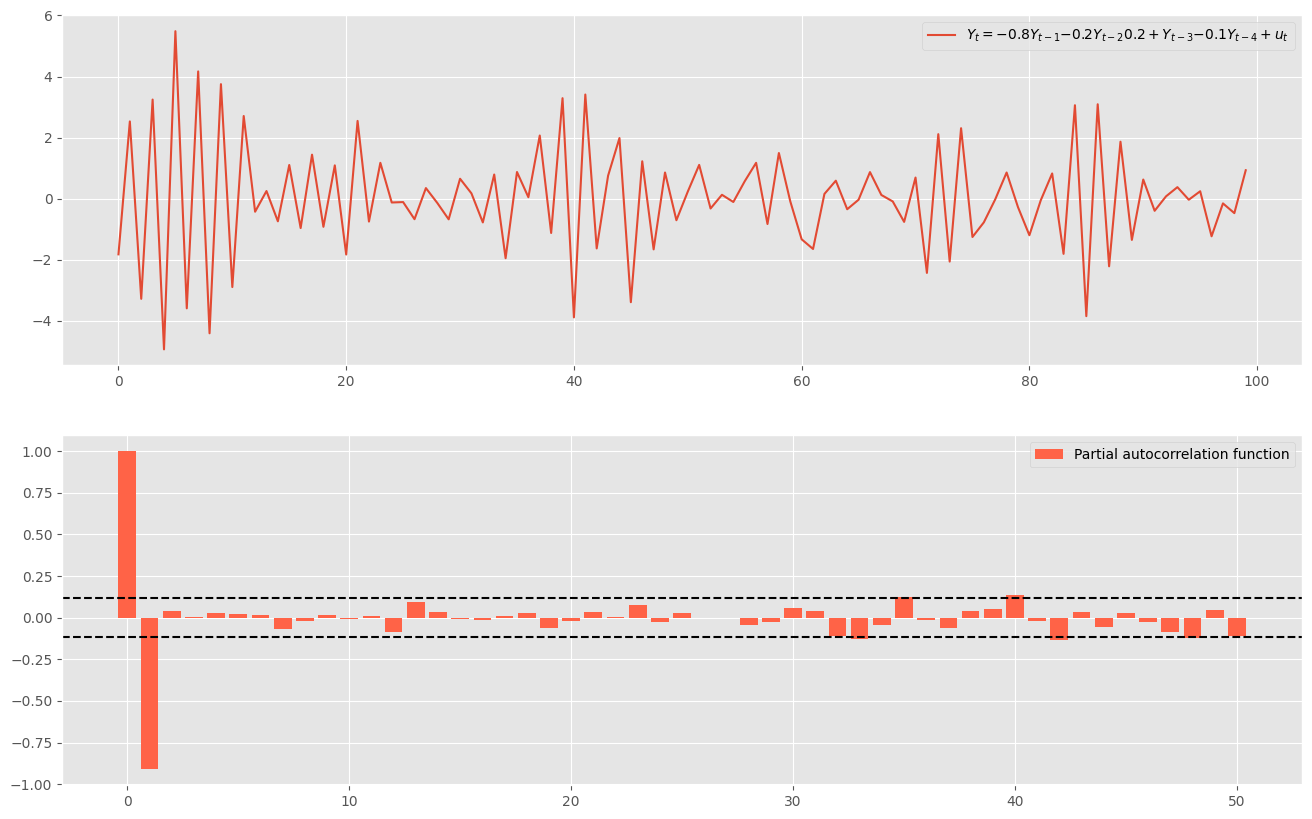

In [19]:
obs = 300

ar_params = np.array([1, 0.8, 0.2, -0.2, 0.1])
ma_params = np.array([1])
ar4 = ArmaProcess(ar_params, ma_params)
ar4_sim = ar1.generate_sample(nsample=obs)
ar4_sim = pd.DataFrame(ar4_sim, columns=["AR(4)"])
ar4_pacf = pacf_func(ar4_sim.values, nlags=50)


fig, ax = plt.subplots(figsize=(16, 10), nrows=2, ncols=1)
ax[0].plot(
    ar1_sim,
    label="$Y_t = {%s}Y_{t-1} {%s}Y_{t-2} {%s}+Y_{t-3} {%s}Y_{t-4}+u_t$"
    % (-ar_params[1], -ar_params[2], -ar_params[3], -ar_params[4]),
)
ax[0].legend()
ax[1].bar(
    np.arange(len(ar4_pacf)),
    ar4_pacf,
    color="tomato",
    label="Partial autocorrelation function",
)
ax[1].axhline(y=2 / np.sqrt(obs), linestyle="--", color="k")
ax[1].axhline(y=-2 / np.sqrt(obs), linestyle="--", color="k")
ax[1].legend()
plt.show()

Only lag $1$ is significant, we could estimate it with $\text{AR(1)}$, the better idea is to loop the estimation to plot the $\text{AIC}$ and $\text{BIC}$.

In [20]:
aic, bic = [], []
for i in range(10):
    mod_obj = ARIMA(ar4_sim, order=(i, 0, 0))
    result = mod_obj.fit()
    aic.append(result.aic)
    bic.append(result.bic)

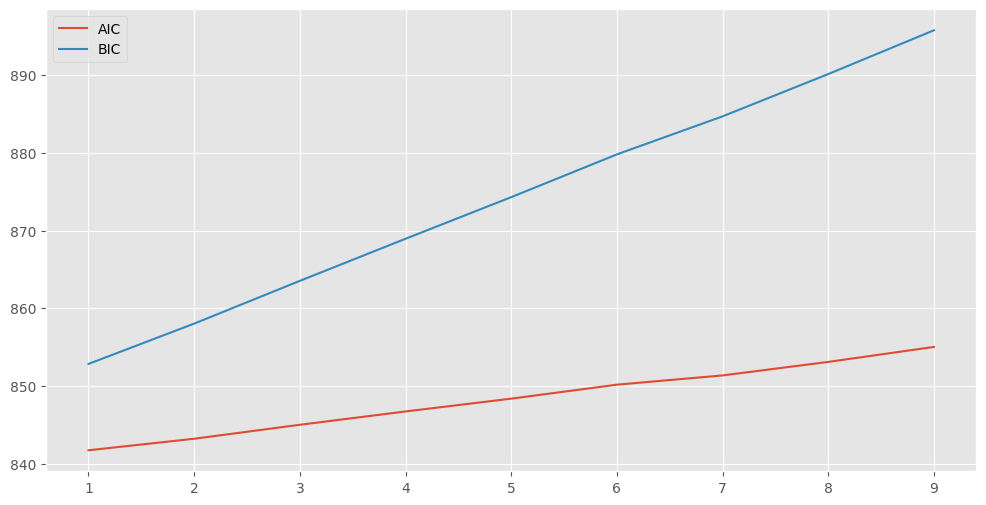

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, 10), aic[1:10], label="AIC")
ax.plot(range(1, 10), bic[1:10], label="BIC")
ax.legend()
plt.show()

$\text{BIC}$ is monotonically increasing, $\text{AIC}$ reaches the lowest at the second lag, however we always choose the simpler model to fit, in this case an $\text{AR(1)}$ model.

In [22]:
mod_obj = ARIMA(ar4_sim, order=(1, 0, 0))
result = mod_obj.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  AR(4)   No. Observations:                  300
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -417.862
Date:                Sun, 09 Jun 2024   AIC                            841.724
Time:                        19:00:33   BIC                            852.835
Sample:                             0   HQIC                           846.170
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0153      0.029     -0.520      0.603      -0.073       0.042
ar.L1         -0.9097      0.024    -37.514      0.000      -0.957      -0.862
sigma2         0.9436      0.083     11.438      0.0

# <font face="gotham" color="purple"> Meta Trader 5 Data </font>

If you have a MetaTrader 5 account, install the ```MetaTrader5``` library, then run the codes below to login the account.
```
import MetaTrader5 as mt5
login = 123456
password = 'abcdefgh'
server = 'XXXXXXX-Demo'
 
mt5.initialize()
mt5.login(login, password, server)
```

Then you can retrieve high frequency data from your broker's server, for instance here we retrieve one minute candlesticks data of $\text{USDJPY}$. ```start_bar``` means the current bar, ```num_bars``` is the number of bars all before the current bar.

```
symbol = 'USDJPY'
timeframe = 1
start_bar = 0
num_bars = 5000
 bars = mt5.copy_rates_from_pos(symbol, timeframe, start_bar, num_bars)
```

Because the time column is present in Unix timestamp, some conversion has to be done as below

```
kbars = pd.DataFrame(bars)

time =[]
for i in range(len(kbars['time'])):
    time.append(dt.datetime.fromtimestamp(kbars['time'][i]))
    
kbars['time'] = time
```

If you need it for later research, save it as a ```.csv``` file
```
kbars.to_csv('USDJPY_1m.csv', index=False)
```

I have uploaded this dataset onto repository.

In [23]:
usdjpy = pd.read_csv("USDJPY_1m.csv")

In [24]:
fig = go.Figure(
    data=[
        go.Candlestick(
            x=usdjpy["time"],
            open=usdjpy["open"],
            high=usdjpy["high"],
            low=usdjpy["low"],
            close=usdjpy["close"],
        )
    ]
)

fig.update_layout(
    xaxis_rangeslider_visible=False, autosize=False, width=1100, height=700
)

fig.show()

# <font face="gotham" color="purple"> MA Model </font>

Here is an $\text{MA(1)}$ model
$$
Y_{t}= u_{t}+\theta_{1} u_{t-1}
$$

In [25]:
ar_params = np.array([1])
ma_params = np.array([1, 0.9])
ma1 = ArmaProcess(ar_params, ma_params)
ma1_sim = ma1.generate_sample(nsample=100)
ma1_sim = pd.DataFrame(ma1_sim, columns=["MA(1)"])
ma1_acf = acf_func(ma1_sim.values, fft=False, nlags=50)

ar_params1 = np.array([1])
ma_params1 = np.array([1, -0.9])
ma1_neg = ArmaProcess(ar_params1, ma_params1)
ma1_sim_neg = ma1_neg.generate_sample(nsample=100)
ma1_sim_neg = pd.DataFrame(ma1_sim_neg, columns=["MA(1)"])
ma1_acf_neg = acf_func(ma1_sim_neg.values, fft=False, nlags=50)

ar_params2 = np.array([1])
ma_params2 = np.array([1, 0.8, 0.2])
ma2 = ArmaProcess(ar_params2, ma_params2)
ma2_sim = ma2.generate_sample(nsample=100)
ma2_sim = pd.DataFrame(ma2_sim, columns=["MA(2)"])
ma2_acf = acf_func(ma2_sim.values, fft=False, nlags=50)

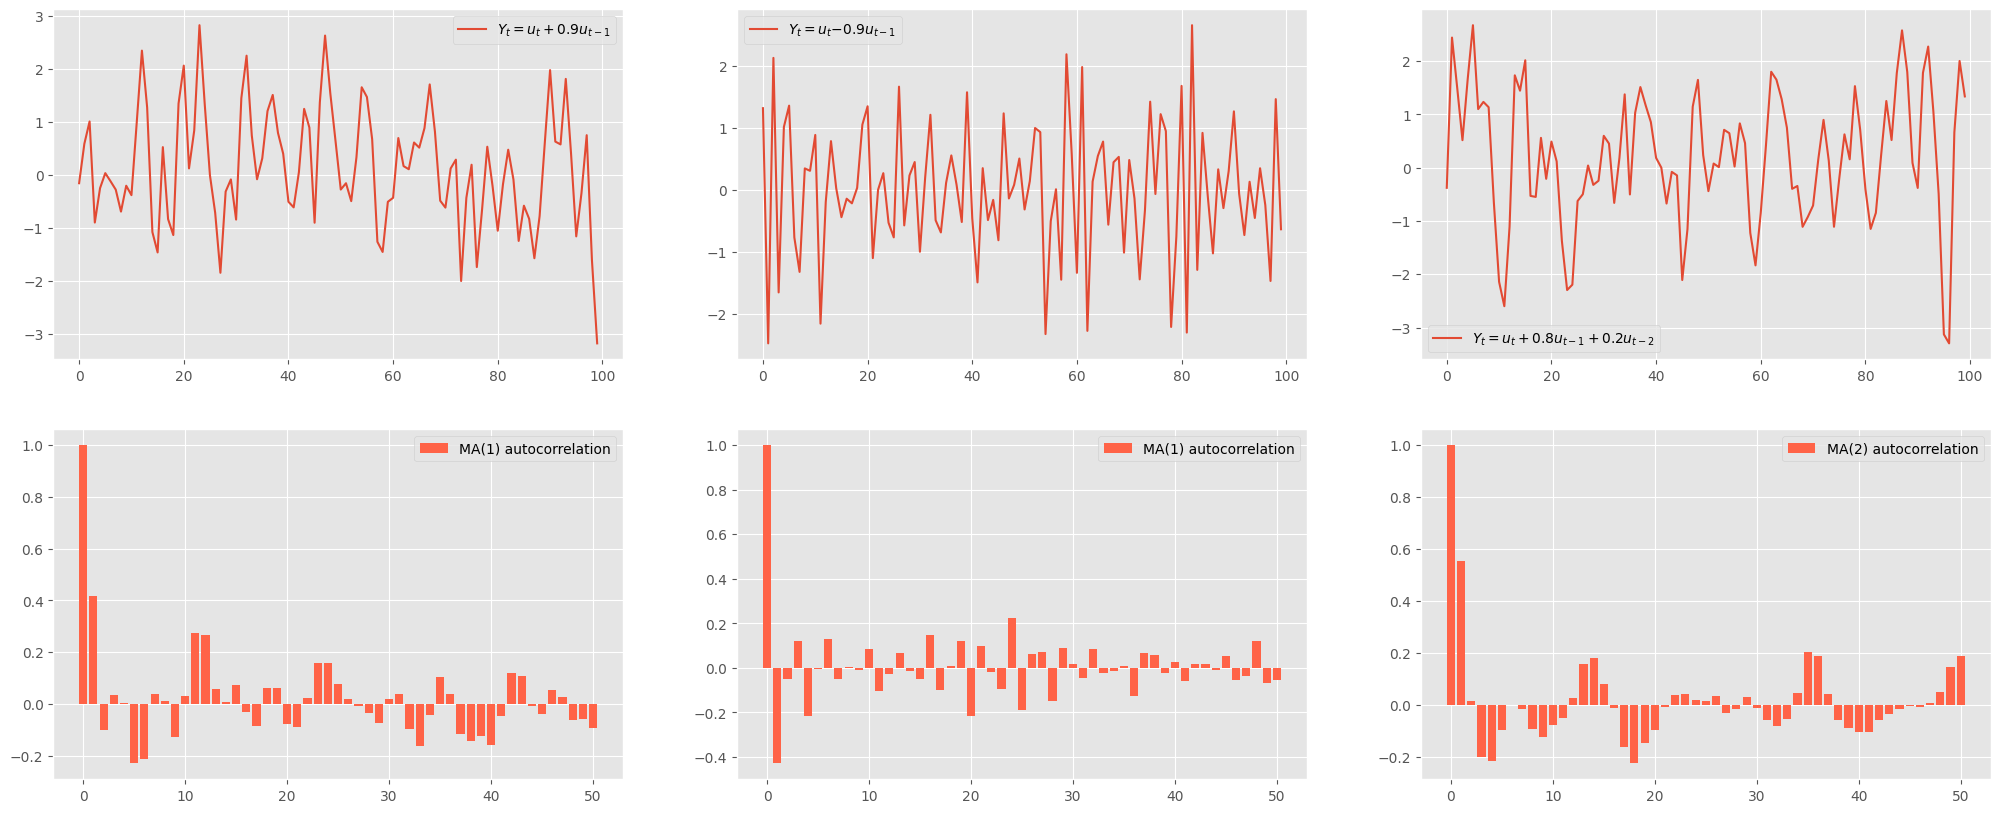

In [26]:
fig, ax = plt.subplots(figsize=(25, 10), nrows=2, ncols=3)
ax[0, 0].plot(ma1_sim, label="$Y_t = u_t + {%s} u_{t-1}$" % (ma_params[1]))
ax[0, 0].legend()
ax[1, 0].bar(
    np.arange(len(ma1_acf)), ma1_acf, color="tomato", label="MA(1) autocorrelation"
)
ax[1, 0].legend()

ax[0, 1].plot(ma1_sim_neg, label="$Y_t =  u_t  {%s} u_{t-1}$" % (ma_params1[1]))
ax[0, 1].legend()
ax[1, 1].bar(
    np.arange(len(ma1_acf_neg)),
    ma1_acf_neg,
    color="tomato",
    label="MA(1) autocorrelation",
)
ax[1, 1].legend()

ax[0, 2].plot(
    ma2_sim,
    label="$Y_t =  u_t   +{%s} u_{t-1}+ {%s} u_{t-2}  $"
    % (ma_params2[1], ma_params2[2]),
)
ax[0, 2].legend()
ax[1, 2].bar(
    np.arange(len(ma2_acf)), ma2_acf, color="tomato", label="MA(2) autocorrelation"
)
ax[1, 2].legend()
plt.show()

# <font face="gotham" color="purple">  Estimation and Forecast of MA</font> 

In [27]:
mod_obj = ARIMA(ma1_sim_neg, order=(0, 0, 1))
result = mod_obj.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  MA(1)   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -125.815
Date:                Sun, 09 Jun 2024   AIC                            257.630
Time:                        19:00:36   BIC                            265.445
Sample:                             0   HQIC                           260.793
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.003      1.348      0.178      -0.002       0.010
ma.L1         -0.9993      1.873     -0.534      0.594      -4.669       2.671
sigma2         0.6927      1.274      0.544      0.5

In [28]:
res_predict = result.predict(start=5, end=110)

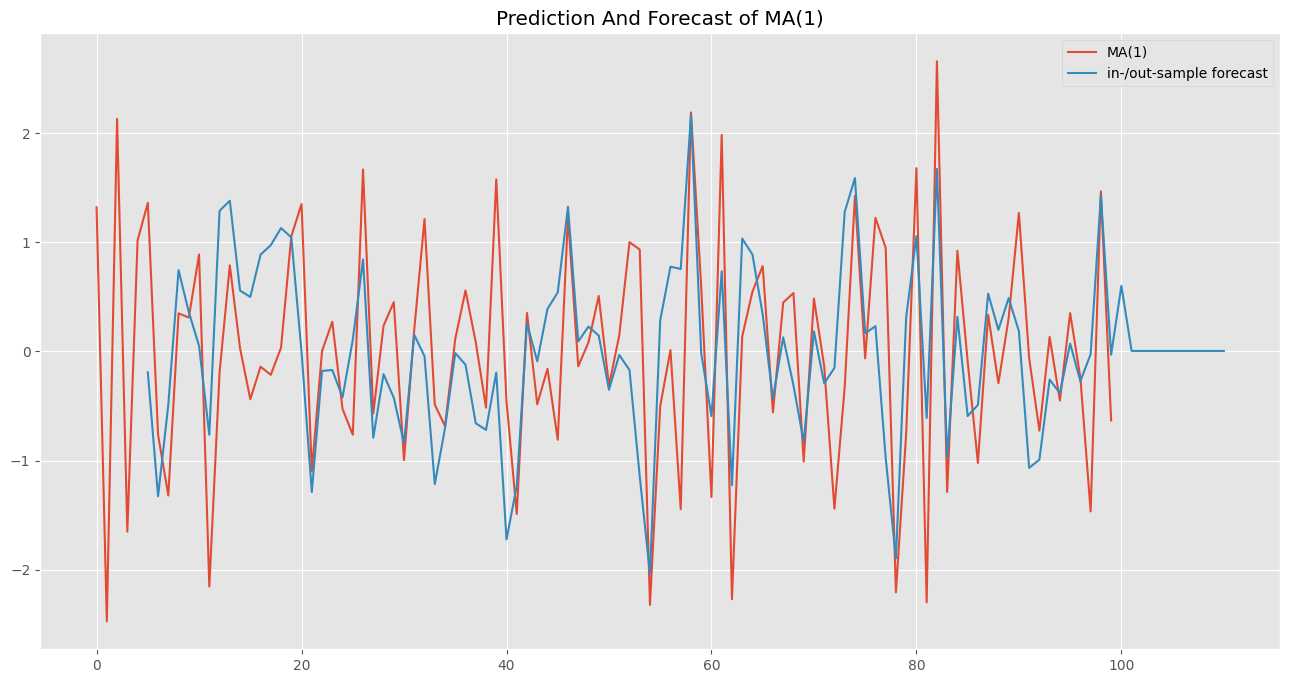

In [29]:
ma1_sim_neg.plot(figsize=(16, 8))
res_predict.plot(
    label="in-/out-sample forecast", title="Prediction And Forecast of MA(1)"
)
plt.legend()
plt.show()

Note that all forecasts beyond one-step ahead forecast will all be the same, namely a straight line.

# <font face="gotham" color="purple"> Connection of AR and MA </font>

We can show any $\text{AR(1)}$ can be rewritten as an $\text{MA($\infty$)}$ model
$$
\text{AR(1)}: \qquad Y_{t}=\phi_0+\phi_{1} Y_{t-1}+u_{t}
$$
Perform a recursive substitution
\begin{align}
y_t &= \phi_0 + \phi_1(\phi_0 + \phi_1y_{t-2}+u_{t-1})+u_t = \phi_0 + \phi_1\phi_0+\phi_1^2y_{t-2}+\phi_1u_{t-1}+u_t\\
    &= \phi_0 + \phi_1\phi_0+\phi_1^2(\phi_0+\phi_1y_{t-3}+u_{t-2})+\phi_1u_{t-1}+u_t=\phi_0 + \phi_1\phi_0 +\phi_1^2\phi_0 +\phi_1^3y_{t-3}+\phi_1^2u_{t-2}+\phi_1u_{t-1}+u_t\\
    &\qquad\vdots\\
    &=\frac{\phi_0}{1-\phi_1}+\sum_{i=0}^\infty\phi_1^iu_{t-1}
\end{align}
It holds because of the fact
$$
\lim_{i\rightarrow\infty}\phi_1^iy_{t-i}=0
$$

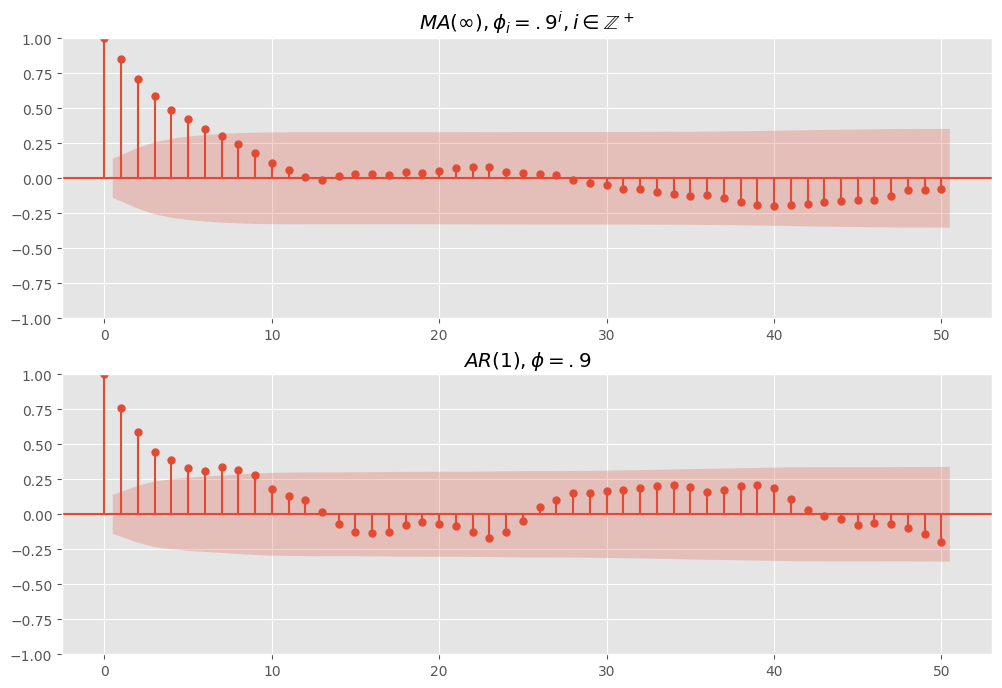

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
ar = np.array([1])
ma = np.array([0.8**i for i in range(100)])
mod_obj = ArmaProcess(ar, ma)
ma_sim = mod_obj.generate_sample(nsample=200)
g = plot_acf(
    ma_sim, ax=ax[0], lags=50, title="$MA(\infty), \phi_i = .9^i, i\in \mathbb{Z}^+$"
)

ar = np.array([1, -0.8])
ma = np.array([1])
mod_obj = ArmaProcess(ar, ma)
ar_sim = mod_obj.generate_sample(nsample=200)
g = plot_acf(ar_sim, ax=ax[1], lags=50, title="$AR(1), \phi=.9$")

# <font face="gotham" color="purple"> ARMA and ARIMA </font>

Now we combine $\text{AR}$ and $\text{MA}$ models as $\text{ARMA}$ and $\text{ARMIA}$.

An $\text{ARMA}(1,1)$ process is a combination of $\text{AR}$ and $\text{MA}$
$$
Y_{t}=\phi_0+\phi_{1} Y_{t-1}+\theta_{0} u_{t}+\theta_{1} u_{t-1}
$$

In general, $\text{ARMA}(p,q)$ process has the form
$$
Y_t = \phi_0 + \phi_i\sum_{i=1}^pY_{t-i}+\sum_{i=1}^q\theta_i u_{t-i}
$$

And $\text{ARIMA}$ model is essentially the same as $\text{ARMA}$, if we have to difference a series $d$ times to render it stationary then apply the $\text{ARIMA}$ model, we say that the original time series is $\text{ARIMA}(p,d,q)$. 

With the same token, $\text{ARIMA}(p,0,q)$ process is the same as $\text{ARMA}(p,q)$.

In [31]:
usdjpy = pd.read_csv("USDJPY_1m.csv")

In [32]:
usdjpy_close = usdjpy["close"].dropna()

In [33]:
mod_obj = ARIMA(usdjpy_close, order=(2, 1, 2))

In [34]:
results = mod_obj.fit()

In [35]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 5000
Model:                 ARIMA(2, 1, 2)   Log Likelihood               17568.668
Date:                Sun, 09 Jun 2024   AIC                         -35127.336
Time:                        19:00:38   BIC                         -35094.751
Sample:                             0   HQIC                        -35115.915
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9867      0.553      1.785      0.074      -0.097       2.070
ar.L2         -0.2962      0.530     -0.559      0.576      -1.334       0.742
ma.L1         -0.9737      0.555     -1.753      0.0

<Axes: >

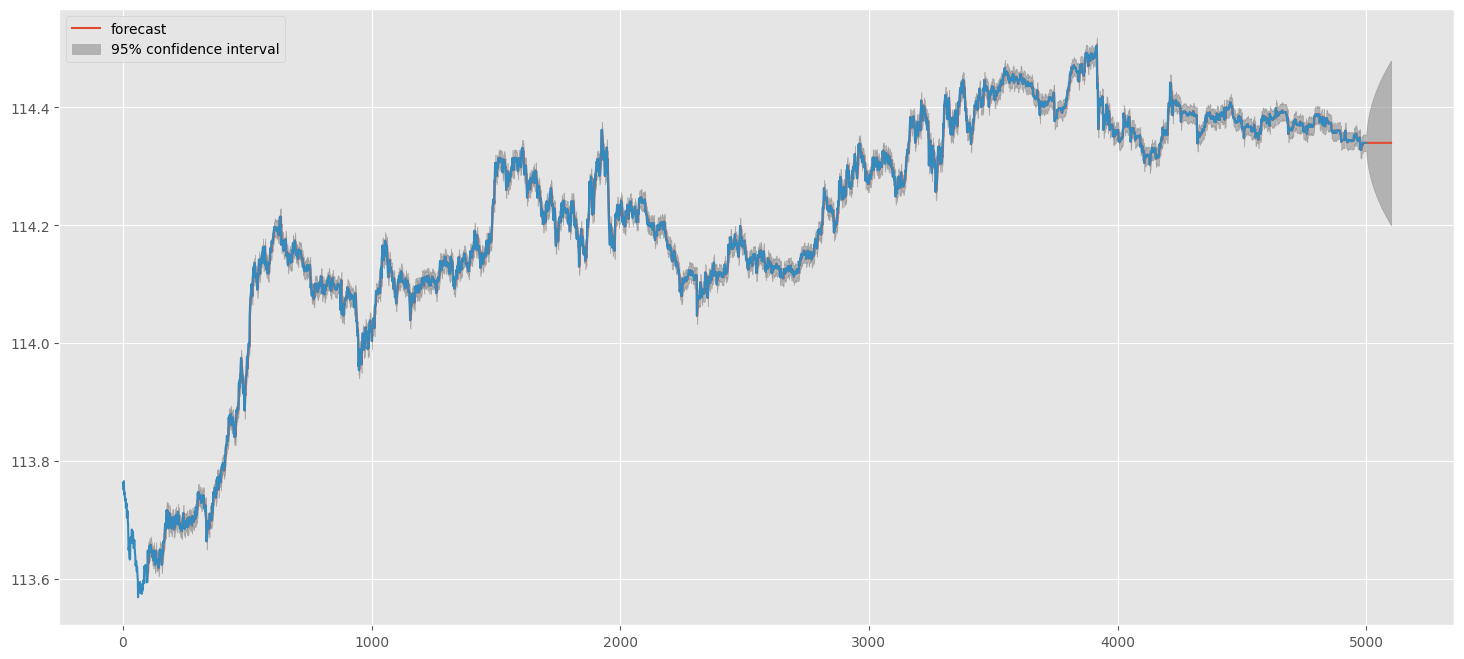

In [36]:
g = tsa.plot_predict(results, 100, 5100)
usdjpy_close.plot(figsize=(18, 8))

# <font face="gotham" color="purple"> The Box-Jenkins Methodology </font>

With so many options at hands, what model to apply to a time series? This is where **Box-Jenkins Methodology** kick in, which provides a systematic method of **identifying**, **estimating** and **checking** with $\text{ARIMA}$ models. 

## <font face="gotham" color="purple"> ACF VS PACF </font>

Before discussion of $\text{ARIMA}$ identification, we should understand the difference of **autocorrelation function** (ACF) and **partial autocorrelation function** (PACF), which both are important tools for identifying lags of $\text{ARIMA}$.

We have shown that the formula of sample ACF
\begin{aligned}
&\hat{\gamma}_{k}=\frac{\sum\left(Y_{t}-\bar{Y}\right)\left(Y_{t+k}-\bar{Y}\right)}{n-k} \\
&\hat{\gamma}_{0}=\frac{\sum\left(Y_{t}-\bar{Y}\right)^{2}}{n-1}\\
&\hat{\rho}_{k} =\frac{\hat{\gamma}_{k}}{\hat{\gamma}_{0}}=\frac{\text { covariance at lag } k}{\text { variance }}
\end{aligned}

However, PACF doesn't have a formula. Simply speaking, PACF requires removing all correlations in between. e.g. if you are measuring variables $k$ periods apart, then all influences from other variables in period $<k$ should be eliminated.

Regression with demeaned variables can give us the partial autocorrelation, e.g. 
$$
y_t-\bar{y}=\phi_{21} (y_{t-1}-\bar{y})+\phi_{22} (y_{t-2}-\bar{y})+\phi_{33} (y_{t-3}-\bar{y})+u_{t}
$$
Estimates of $\phi_{kk}$ is the partial correlation at lag $3$.

So how to use ACF and PACF to identify the lags of $\text{ARMA}$ model? First we transform the original data into log difference, then plot both correlograms. 

In [37]:
start = dt.datetime(1980, 1, 1)
end = dt.datetime(2021, 10, 1)
df_cpi = pdr.data.DataReader(["CPIAUCSL"], "fred", start, end)
df_cpi.columns = ["urban_CPI"]
df_cpi = df_cpi.dropna()

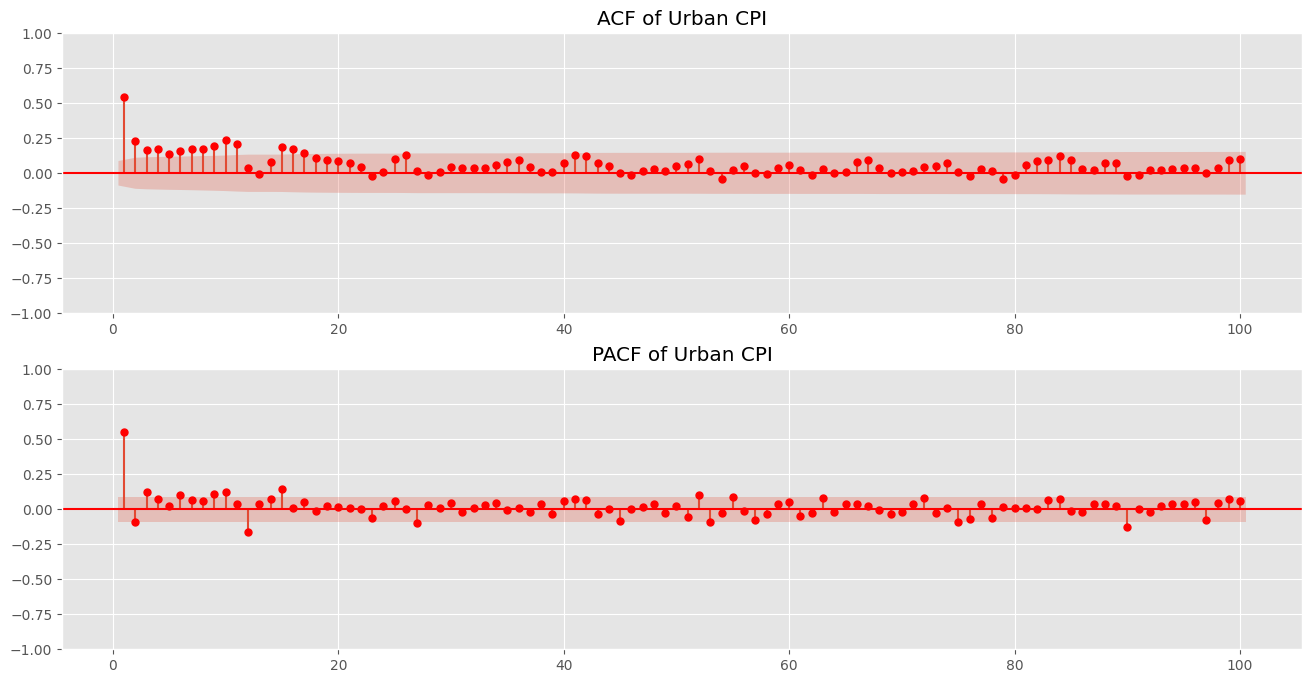

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
fig = plot_acf(
    np.log(df_cpi).diff().dropna(),
    ax=ax[0],
    lags=100,
    color="red",
    zero=False,
    title="ACF of Urban CPI",
)
fig = plot_pacf(
    np.log(df_cpi).diff().dropna(),
    ax=ax[1],
    lags=100,
    color="red",
    zero=False,
    title="PACF of Urban CPI",
    method="ols",
)

## <font face="gotham" color="purple"> Simulation of ACF and PACF </font>

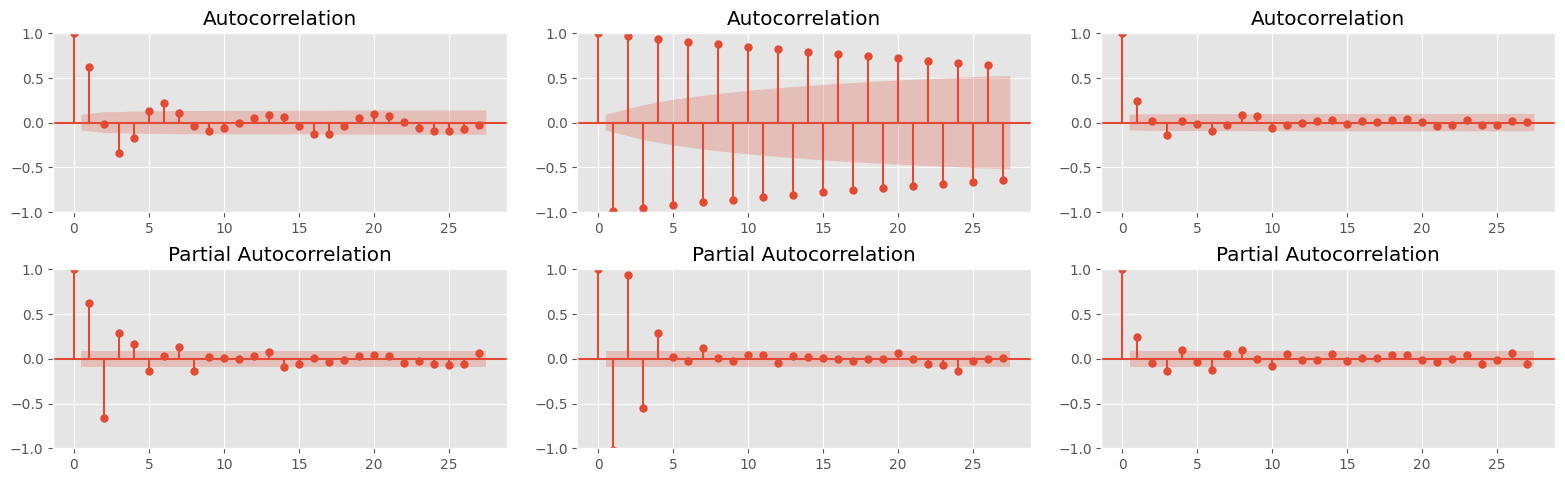

In [39]:
arparams = np.array([[0.63, -0.5], [-0.23, 0.8], [-0.5, -0.5]])
maparams = np.array([[0.58, 0.45], [0.78, 0.34], [0.8, 0.8]])

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 5))
fig.tight_layout(pad=2.0)
ar = np.r_[1, -arparams[0]]
ma = np.r_[1, maparams[0]]
arma22 = ArmaProcess(ar, ma).generate_sample(nsample=500)
fig = plot_acf(arma22, ax=ax[0, 0])
fig = plot_pacf(arma22, ax=ax[1, 0], method="ols")

ar = np.r_[1, -arparams[1]]
ma = np.r_[1, maparams[1]]
arma22 = ArmaProcess(ar, ma).generate_sample(nsample=500)
fig = plot_acf(arma22, ax=ax[0, 1])
fig = plot_pacf(arma22, ax=ax[1, 1], method="ols")

ar = np.r_[1, -arparams[2]]
ma = np.r_[1, maparams[2]]
arma22 = ArmaProcess(ar, ma).generate_sample(nsample=500)
fig = plot_acf(arma22, ax=ax[0, 2])
fig = plot_pacf(arma22, ax=ax[1, 2], method="ols")

How you set the parameters has to be consistent with lag operator form of $\text{ARMA}$ model as below, which is the exact reason we set the opposite sign of $\phi$'s.

$$
\left(1-\phi_{1}L-\ldots-\phi_{p}L^{p}\right)y_{t} =
        \left(1+\theta_{1}L+\ldots+\theta_{q}L^{q}\right)\varepsilon_{t}
$$

## <font face="gotham" color="purple"> Identification of ARMA </font>

The identification of $\text{ARMA}$ doesn't have clear-cut rules, but here are four guideline to help you decide the lags of $\text{ARMA}$ model.
1. If PACF shows significant lags through $p$ and ACF dampens exponentially, try $\text{AR}(p)$
2. If ACF shows significant lags through $q$ and PACF dampens exponentially, try $\text{MA}(q)$
3. Both ACF and PACF dampen exponentially with significant lags $(p, q)$, try $\text{ARMA}(p, q)$ 

# <font face="gotham" color="purple"> Vector Autoregression (VAR) </font>

A **Vector Autogression** model has at least two variables, though it seems like a system of equations, every equation can be estimated by independently by OLS. This is viable because VAR model doesn't differentiate endogenous or exogenous variables.

The general two variable $\text{VAR(p)}$ model has the form
\begin{align}
Y_t &= \alpha_1 + \sum_{i=1}^p\beta_i Y_{t-i} +\sum_{i=1}^p\gamma_i X_{t-i}+u_{1t}\\
X_t &= \alpha_2 + \sum_{i=1}^p\eta_i X_{t-i} +\sum_{i=1}^p\theta_i Y_{t-i}+u_{2t}
\end{align}
where $Y$ and $X$ are variables, $\alpha$'s are constants, $u_1$ and $u_t$ are shocks in the context of VAR.

Note that VAR is a type atheortical model, unlike simultaneous-equation models, VAR doesn't deal with model identification which is a good news for practitioners. However, it doesn't mean you can add any variables into the model, if the variables have little connection with each other, the forecasting power is also severely undermined. 

To illustrate estimation process, we import quarterly GDP and monthly consumer sentiment from FRED, however in order to take advantage of abundant monthly observation of consumer sentiment, quarterly GDP shall be resampled into monthly by linear interpolation.

In [40]:
start = dt.datetime(1980, 1, 1)
end = dt.datetime(2021, 10, 1)
df = pdr.data.DataReader(["GDP", "UMCSENT"], "fred", start=start, end=end)
df.dropna()
df.columns = ["GDP", "Consumer_confidence"]

In [41]:
df["GDP"] = df["GDP"].resample("MS").interpolate(method="linear")
df.head()

GDP  Consumer_confidence
DATE                                        
1980-01-01  2789.842000                 67.0
1980-02-01  2792.345333                 66.9
1980-03-01  2794.848667                 56.5
1980-04-01  2797.352000                 52.7
1980-05-01  2817.062333                 51.7

Inspect the dataframe, we have quite abundant observations, $504$ in total.

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 1980-01-01 to 2021-10-01
Freq: MS
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GDP                  502 non-null    float64
 1   Consumer_confidence  502 non-null    float64
dtypes: float64(2)
memory usage: 11.8 KB


Perform ADF test, keep in mind that $H_0$ of Augmented Dicky-Fuller test is nonstationary. The results indicate that we only reject null hypothesis that consumer sentiment index is nonstationary, i.e. highly likely consumer sentiment is stationary.

In [43]:
results_dickeyfuller = adfuller(df["GDP"])
print("ADF Statistic of Quarterly GDP: %f" % results_dickeyfuller[0])
print("p-value: %f" % results_dickeyfuller[1])

ADF Statistic of Quarterly GDP: 3.861765
p-value: 1.000000


In [44]:
results_dickeyfuller = adfuller(df["Consumer_confidence"])
print("ADF Statistic of Consumer Sentiment: %f" % results_dickeyfuller[0])
print("p-value: %f" % results_dickeyfuller[1])

ADF Statistic of Consumer Sentiment: -3.007303
p-value: 0.034218


Change GDP level data into growth rate.

In [45]:
df["GDP_growth"] = df["GDP"].pct_change()
df = df.dropna()
df = df.drop(["GDP"], axis=1)

Observe the moving pattern of both series.

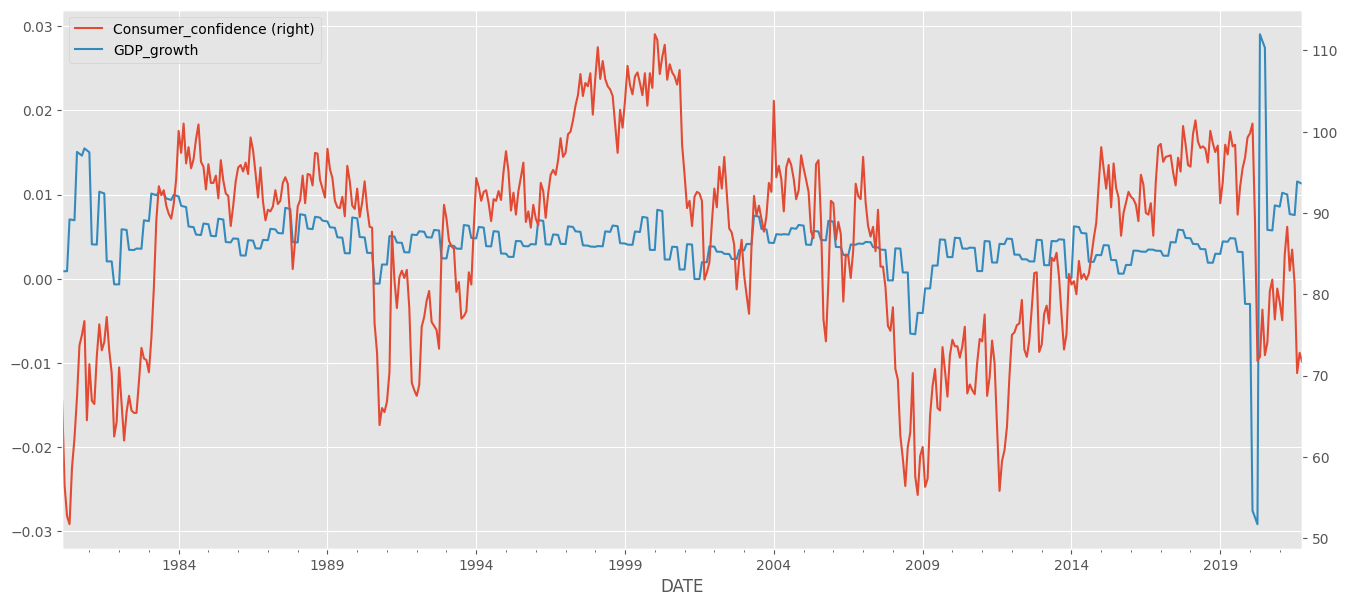

In [46]:
ax = df.plot(secondary_y="Consumer_confidence", figsize=(16, 7))
plt.show()

Test stationarity of GDP growth rate.

In [47]:
results_dickeyfuller = adfuller(df["GDP_growth"])
print("ADF Statistic: %f" % results_dickeyfuller[0])
print("p-value: %f" % results_dickeyfuller[1])

ADF Statistic: -4.666394
p-value: 0.000097


The result indicates GDP growth rate is stationary. Then we instantiate a VAR object.

In [48]:
from statsmodels.tsa.api import VAR

var_model = VAR(df, freq="MS")

Fit the model, order of lags is chosen based on $\text{BIC}$ though both criteria will be calculated. The default maximum tested lags are $12$ and I suggest no more than $12$, the VAR parameters consumes degree of freedom fast!

Suppose you have a $5$ variable with $5$ lags VAR model, each equation has $25+1=26$ parameters, in total $26\times5=130$ parameters, that means your observations must way more than this number to function properly.

In [49]:
var_results = var_model.fit(verbose=True, ic="bic", method="ols")

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 7, BIC -> 4, FPE -> 7, HQIC ->  7>
Using 4 based on bic criterion


Python streamlined the whole process, after choosing the appropriate lags, estimation can be promptly printed.

In [50]:
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 09, Jun, 2024
Time:                     19:01:07
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -8.92354
Nobs:                     497.000    HQIC:                  -9.01614
Log likelihood:           862.952    FPE:                0.000114383
AIC:                     -9.07596    Det(Omega_mle):     0.000110350
--------------------------------------------------------------------
Results for equation Consumer_confidence
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          4.305388         1.299787            3.312           0.001
L1.Consumer_confidence         0.908926         0.045336           20.049           0.000
L1.GDP_gro

According to the results, the estimated VAR model is
\begin{align}
Y_t&=  0.001966 + 0.86 Y_{t-1} + 0.0058 Y_{t-2}-0.52 Y_{t-3}+0.39 Y_{t-4} -0.000061 S_{t-1} +0.000043 S_{t-2} + 0.00004 S_{t-3}-0.000031 S_{t-4}\\
S_t&=   4.336760 + 0.90 S_{t-1} -0.069 S_{t-2}+0.058 S_{t-3}+0.048 S_{t-4} +189.72 Y_{t-1} -39.39 Y_{t-2} + 40.49 Y_{t-3} + 44.57 Y_{t-4}
\end{align}

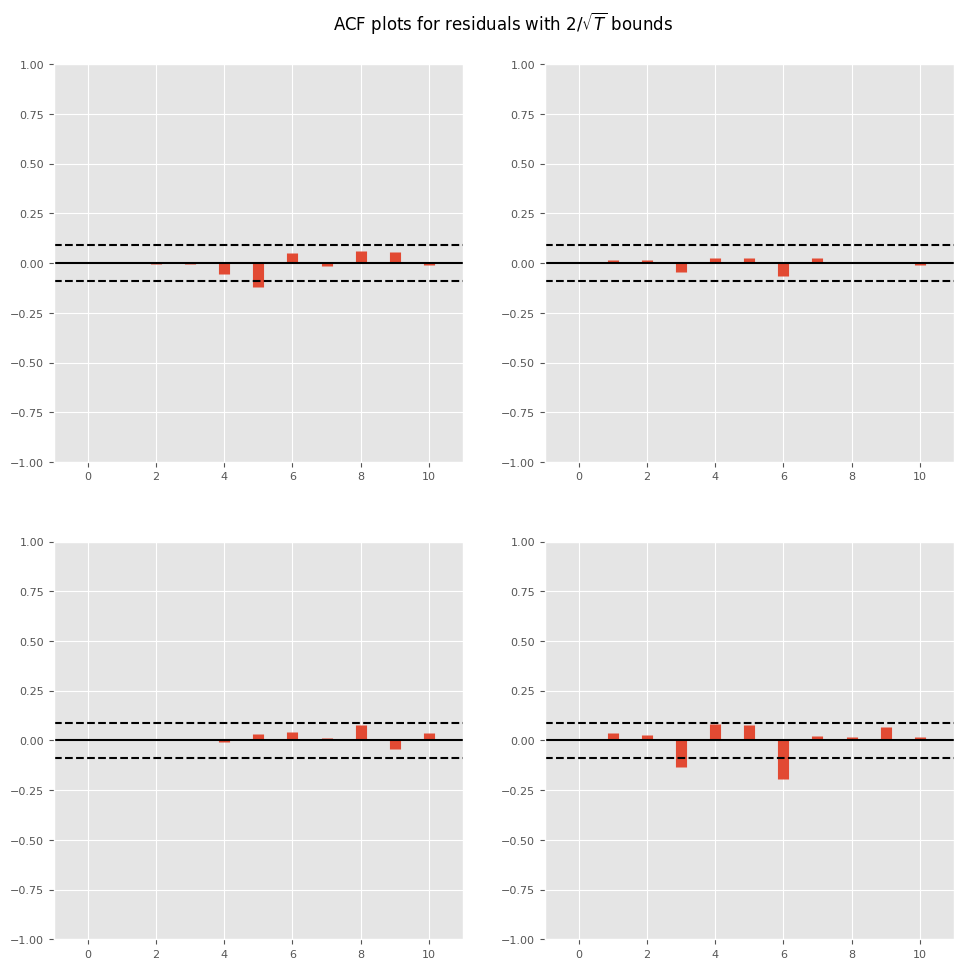

In [51]:
g_accor = var_results.plot_acorr()

In [52]:
lag_order = var_results.k_ar
var_results.forecast(df.values[-lag_order:], 5)

array([[7.43906198e+01, 7.82470060e-03],
       [7.60598061e+01, 6.56419392e-03],
       [7.73728878e+01, 5.41534415e-03],
       [7.82113785e+01, 6.28098690e-03],
       [7.91031342e+01, 6.29991906e-03]])

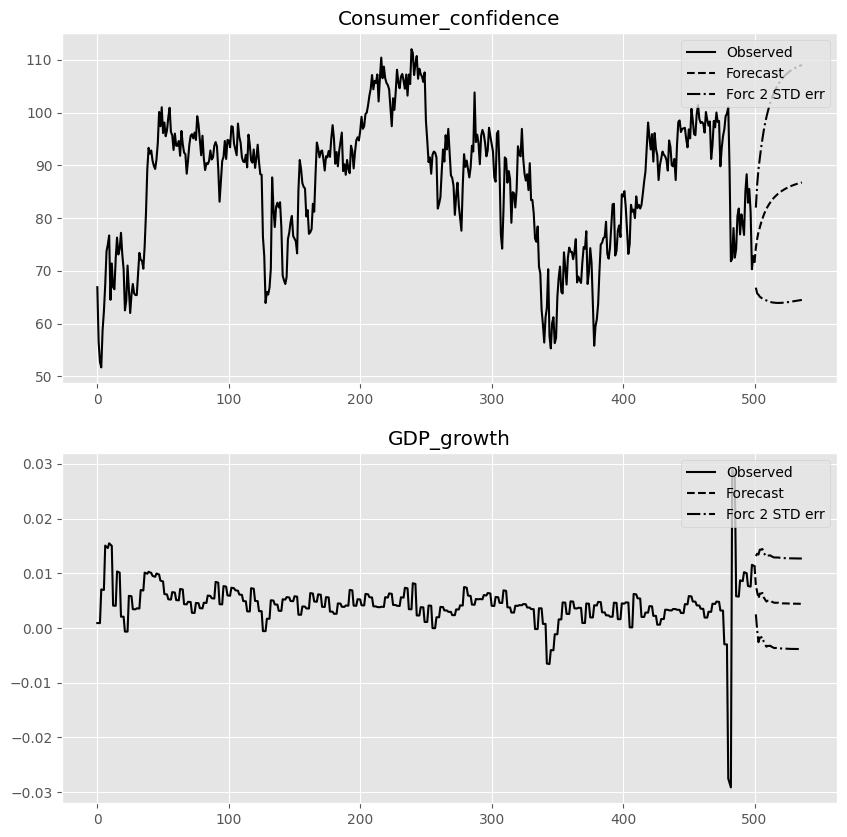

In [53]:
var_results.plot_forecast(36)
plt.show()

In [54]:
var_irf = var_results.irf(36)

As you can see the coefficients are in general difficult to interpret, so the standard practice after estimation is to map out the the **Impulse Response Functions** (IRF), the IRFs trace out the responses of each variables to shocks in disturbance term, such as $u_1$ and $u_2$. 

For instance, the $[0, 0]$ position graph shows how one standard deviation shock on consumer confidence can move itself, the $[0, 1]$ position graph shows the traces of GDP growth after give one standard deviation shock of consumer confidence.

Note the unit on the vertical axis is the number of standard deviation.

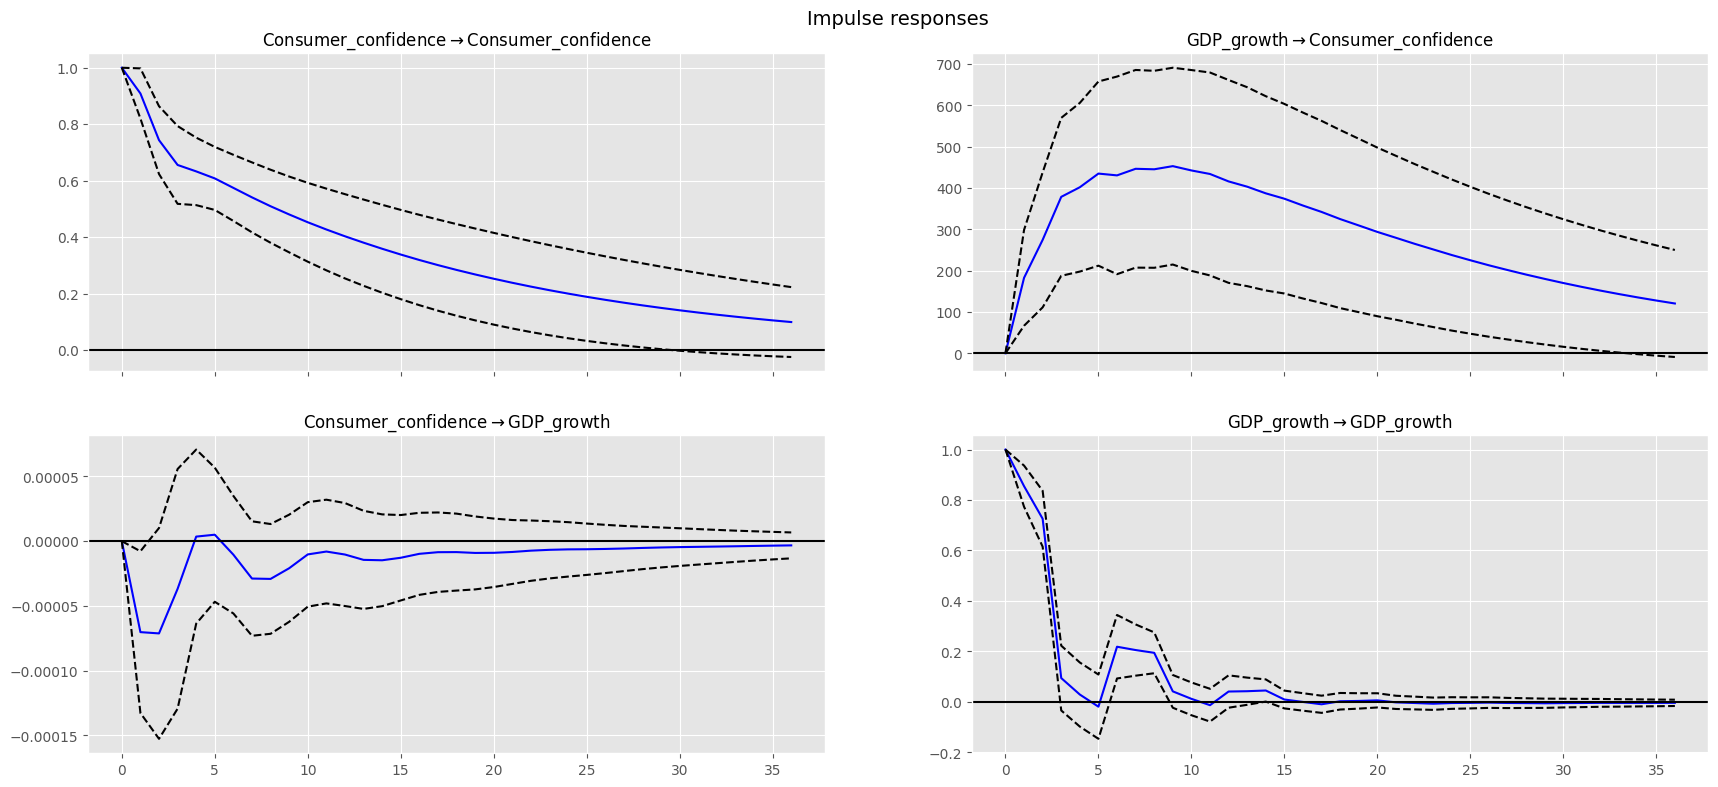

In [55]:
g = var_irf.plot(orth=False, figsize=(18, 8))

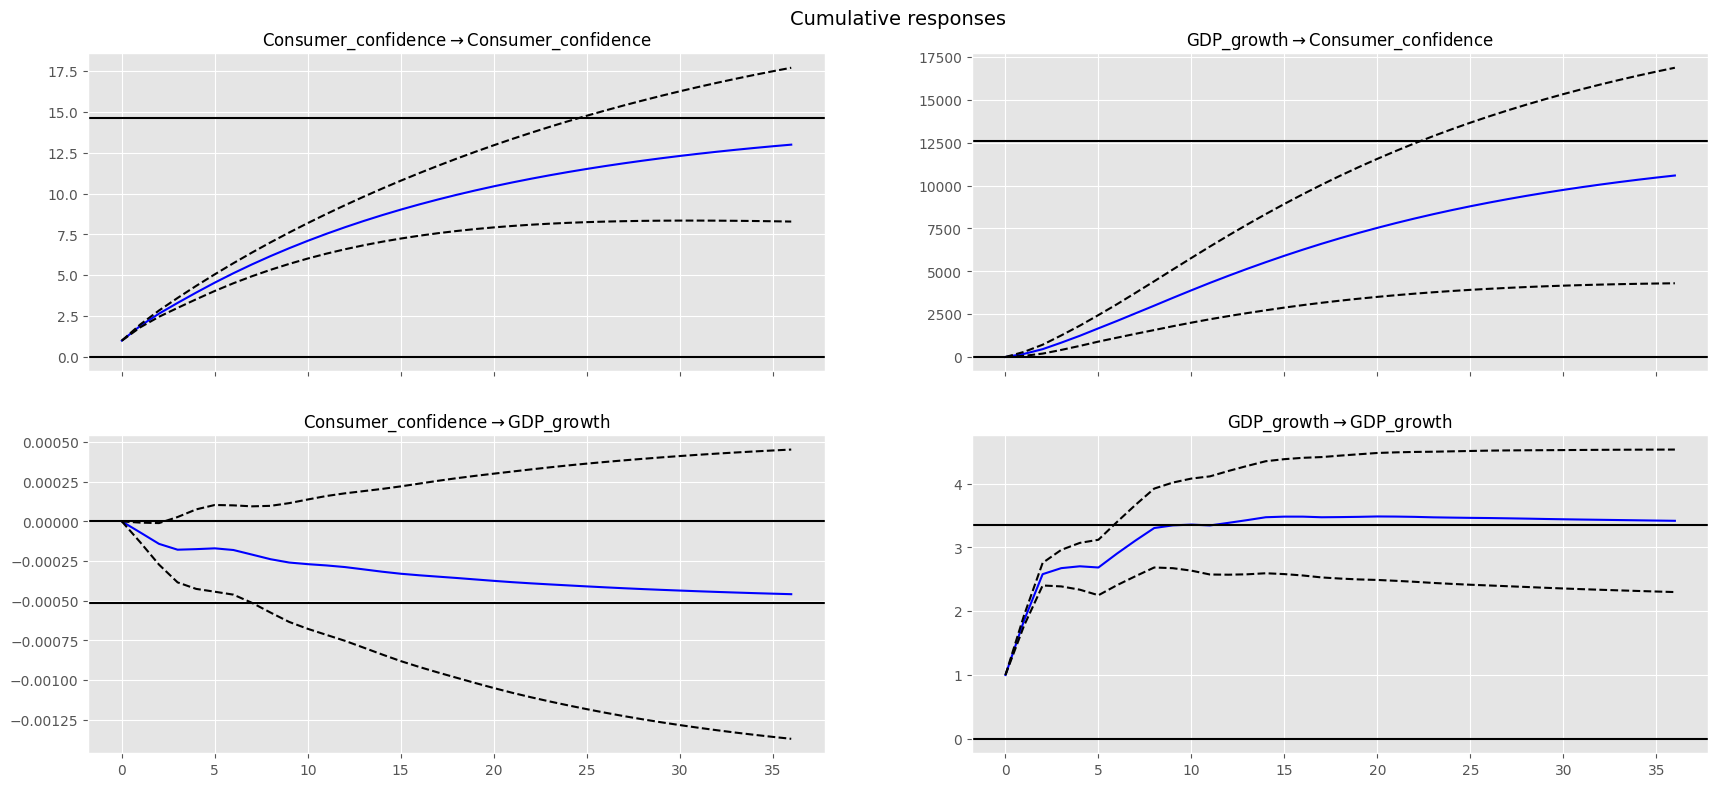

In [56]:
g1 = var_irf.plot_cum_effects(orth=False, figsize=(18, 8))

In [57]:
fevd = var_results.fevd(5)
print(fevd.summary())

FEVD for Consumer_confidence
     Consumer_confidence  GDP_growth
0               1.000000    0.000000
1               0.991167    0.008833
2               0.978325    0.021675
3               0.958555    0.041445
4               0.941820    0.058180

FEVD for GDP_growth
     Consumer_confidence  GDP_growth
0               0.004983    0.995017
1               0.003788    0.996212
2               0.004015    0.995985
3               0.004916    0.995084
4               0.004937    0.995063


None


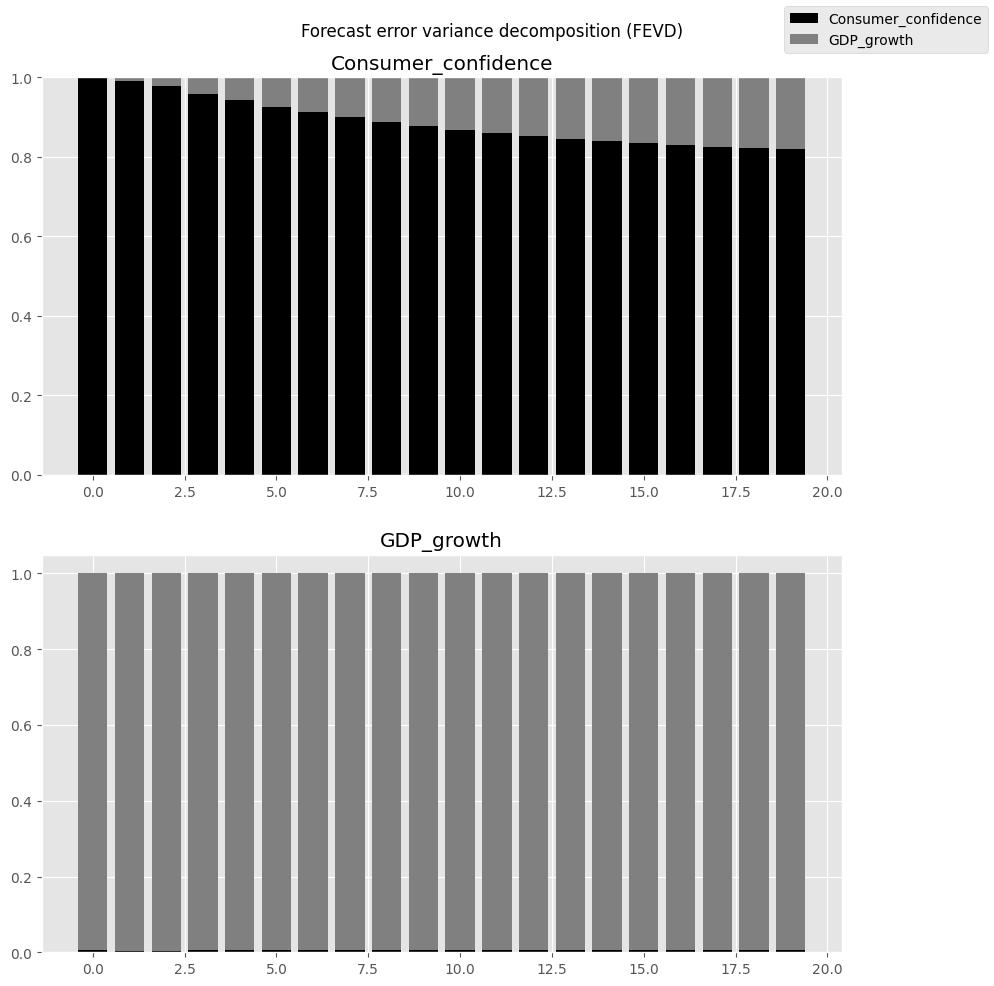

In [58]:
g3 = var_results.fevd(20).plot()

# <font face="gotham" color="purple"> ARCH and GARCH Models </font>

Though we have seen quite many time series, but one important feature of time series we didn't mention is that volatility tend to cluster, called **volatility clustering**.

In [59]:
start = dt.datetime(1950, 1, 1)
ni225 = pdr.data.DataReader("NIKKEI225", "fred", start=start)
ni225 = ni225.dropna()

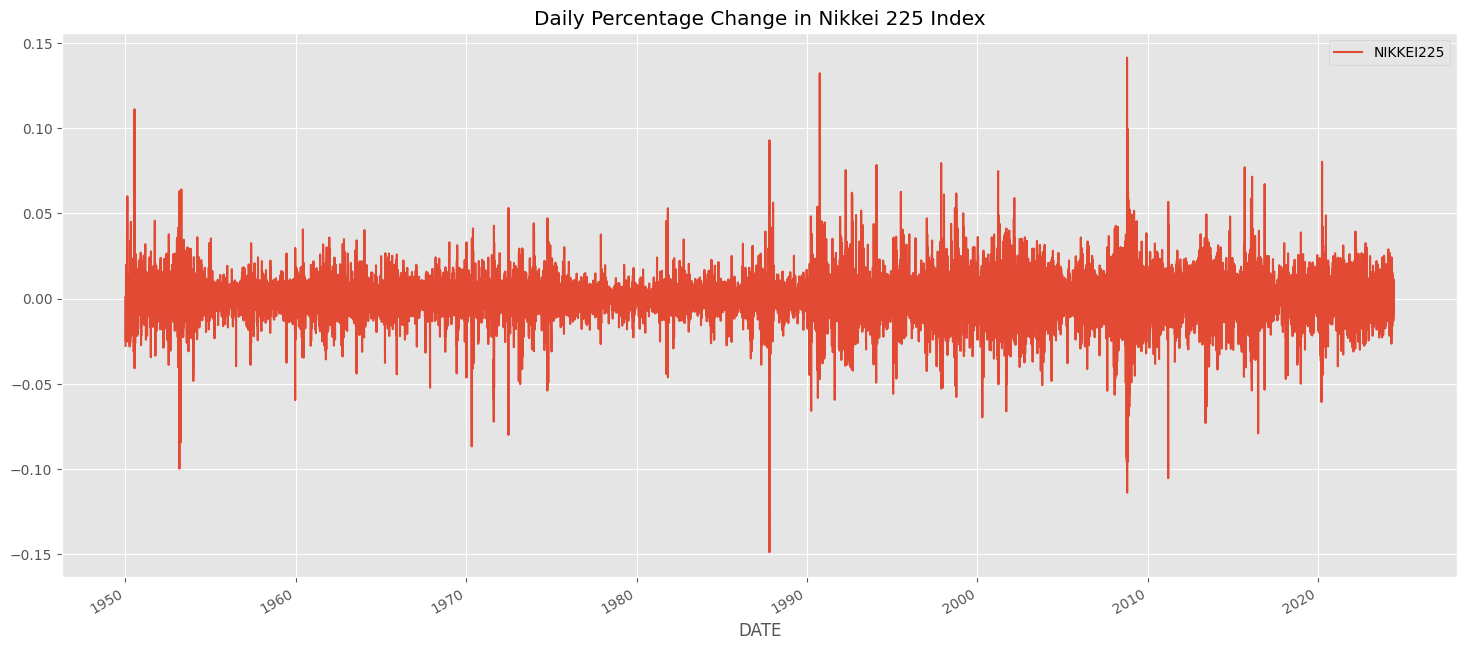

In [60]:
ni225.pct_change().plot(
    figsize=(18, 8), title="Daily Percentage Change in Nikkei 225 Index"
)
plt.show()

There are periods of high volatility and periods of tranquility. Because volatility comes in cluster, the variance of daily percentage change can be forecasted, even though the price itself is difficult to forecast.

The volatility of asset price in the context of finance tells two things: 
1. the risk of owning the asset. 
2. the value of some financial derivatives depends on the value of underlying assets, such as options.


## <font face="gotham" color="purple"> ARCH Model </font>

The most famous model of volatility clustering is **autoregressive conditional heteroskedasticity (ARCH)**. For instance, an $\text{ARCH(1)}$ is
$$
\sigma_t^2 = \alpha_0 + \alpha_1u_{t-1}^2 
$$
where $u$ is the error term of any time series model, such as $\text{ARMA}$, $\sigma_t^2$ represents the variance of error term.

The more general $p$-order ARCH is
$$
\sigma_t^2 =  \alpha_0 + \sum_{i=1}^p\alpha_iu_{t-i}^2=\alpha_{0}+\alpha_{1} u_{t-1}^{2}+\alpha_{2} u_{t-2}^{2}+\cdots+\alpha_{p} u_{t-p}^{2}
$$

## <font face="gotham" color="purple"> GARCH Model </font>

The generalized ARCH (GARCH) simply extend the ARCH to include lagged $\sigma$ itself into the model, an $\text{GARCH(1, 1)}$ is
$$
\sigma_t^2 = \alpha_0 + \alpha_1u_{t-1}^2 +\phi_1\sigma_{t-1}^2
$$
Similarly, $\text{GARCH(p, q)}$
$$
\sigma_t^2=\alpha_0 + \sum_{i=1}^p\alpha_iu_{t-i}^2+\sum_{i=1}^p\phi_i\sigma_{t-i}^2=\alpha_{0}+\alpha_{1} u_{t-1}^{2}+\cdots+\alpha_{p} u_{t-p}^{2}+\phi_{1} \sigma_{t-1}^{2}+\cdots+\phi_{q} \sigma_{t-q}^{2}
$$